# Featurized MNL pipeline

In [ ]:
# =============================================================================
# END-TO-END MNL PIPELINE
# =============================================================================

import numpy as np
import pandas as pd
from scipy.optimize import minimize
from ast import literal_eval
import re

# =============================================================================
# 1. SETUP & DATA LOADING
# =============================================================================
print("--- 1. Loading Data ---")

tx_df = pd.read_csv("groundtruth_transaction_data.csv")
restaurants = pd.read_csv("berkeley_real_restaurants_100.csv")

# Added 'profile_name' to this list
user_cols = ['user_id', 'x', 'y', 'profile', 'profile_name', 'price_tolerance', 'cuisine_rank']


def parse_cuisine_rank(val):
    if isinstance(val, dict): return val
    if not isinstance(val, str): return {}
    # Remove 'np.str_(' artifacts
    s = val.replace("np.str_(", "").replace(")", "")
    try:
        return literal_eval(s)
    except:
        return {}


# Re-create the users table
users = tx_df[user_cols].drop_duplicates(subset='user_id').reset_index(drop=True)
users['cuisine_rank_dict'] = users['cuisine_rank'].apply(parse_cuisine_rank)

print(f"Loaded {len(restaurants)} restaurants.")
print(f"Loaded {len(tx_df)} transactions.")
print(f"Extracted {len(users)} unique users (with Profile Names).")

# =============================================================================
# 2. PREPROCESSING HELPERS
# =============================================================================

def parse_offer_set(val):
    if isinstance(val, list): return val
    if isinstance(val, str):
        try:
            return literal_eval(val)
        except:
            return []
    return []

users['cuisine_rank_dict'] = users['cuisine_rank'].apply(parse_cuisine_rank)
tx_df['offer_set_ids'] = tx_df['offer_set_ids'].apply(parse_offer_set)

# =============================================================================
# 3. MNL FEATURE ENGINEERING (FOR ESTIMATION)
# =============================================================================
print("\n--- 3. Preparing MNL Training Data ---")
# NOTE: For estimation, we let the model LEARN the signs.
# We feed it raw features (Distance, Price Gap) and it should find negative betas.

def get_mnl_features_for_estimation(user_row, rest_row):
    # 1. Cuisine Match (0-1)
    ranks = user_row['cuisine_rank_dict']
    C = len(ranks) if len(ranks) > 0 else 1
    r_rank = ranks.get(rest_row['cuisine'], C)
    x_cuisine = (C - r_rank) / (C - 1) if C > 1 else 0.0

    # 2. Signed Price Gap (Price - Tolerance)
    # If Price > Tolerance, this is positive. Model should learn negative beta.
    x_price_gap = float(rest_row['price_level']) - float(user_row['price_tolerance'])

    # 3. Rating (Normalized)
    x_rating = (float(rest_row['rating_5star']) - 3.0) / 2.0

    # 4. ETA (Normalized Distance)
    dx = user_row['x'] - rest_row['x']
    dy = user_row['y'] - rest_row['y']
    x_eta = np.sqrt(dx**2 + dy**2) / 10.0

    # 5. Intercept
    x_intercept = 1.0

    return np.array([x_cuisine, x_price_gap, x_rating, x_eta, x_intercept])

# Build Training Data
X_list = []
y_indices = []

# Use a sample for speed (e.g., 2000 txns), or all if small
train_tx = tx_df.sample(n=min(2000, len(tx_df)), random_state=42)

for idx, row in train_tx.iterrows():
    u_id = row['user_id']
    user = users[users['user_id'] == u_id].iloc[0]
    offer_ids = row['offer_set_ids']
    chosen_id = row['chosen_id']

    features_in_set = []
    chosen_idx = -1

    for i, rid in enumerate(offer_ids):
        rest = restaurants[restaurants['restaurant_id'] == rid].iloc[0]
        features_in_set.append(get_mnl_features_for_estimation(user, rest))
        if rid == chosen_id:
            chosen_idx = i

    if chosen_idx != -1:
        X_list.append(np.array(features_in_set))
        y_indices.append(chosen_idx)

print(f"Training data ready: {len(X_list)} choices.")

# =============================================================================
# 4. MNL ESTIMATION (TRAINING)
# =============================================================================
print("\n--- 4. Estimating MNL Parameters ---")

def mnl_loss(beta, X_list, y_indices):
    log_lik = 0.0
    for i, X in enumerate(X_list):
        u = X @ beta
        max_u = u.max() # Stability
        exp_u = np.exp(u - max_u)
        log_prob = (u[y_indices[i]] - max_u) - np.log(exp_u.sum())
        log_lik += log_prob
    return -log_lik

beta_init = np.zeros(5)
res = minimize(mnl_loss, beta_init, args=(X_list, y_indices), method='BFGS')

beta_hat = res.x
feature_names = ["CuisineMatch", "PriceGap", "Rating", "ETA", "Intercept"]
print("Estimated Betas (Should be: +Cuisine, -Price, +Rating, -ETA):")
for n, v in zip(feature_names, beta_hat):
    print(f"  {n:12s}: {v:.4f}")

# =============================================================================
# 5. PERSONALIZED OPTIMIZATION (GREEDY)
# =============================================================================
print("\n--- 5. Defining Optimizer ---")

def get_optimal_assortment(user, beta_hat, K=5):
    # Precompute v_i = exp(beta * x) for all items for THIS user
    items = []
    for _, rest in restaurants.iterrows():
        # IMPORTANT: Use the SAME feature function as training!
        x_est = get_mnl_features_for_estimation(user, rest)
        v_i = np.exp(np.dot(beta_hat, x_est))
        items.append({
            'id': rest['restaurant_id'],
            'v': v_i,
            'price': rest['price_level']
        })

    # Greedy Selection for Revenue
    S = [] # list of item dicts
    S_ids = set()

    for _ in range(K):
        best_item = None
        best_rev = -1.0

        # Current Revenue of S
        # R(S) = Sum(p * v) / (1 + Sum(v))
        num = sum(x['price'] * x['v'] for x in S)
        denom = 1.0 + sum(x['v'] for x in S)
        curr_rev = num / denom

        # Try adding candidates
        for item in items:
            if item['id'] in S_ids: continue

            new_num = num + item['price'] * item['v']
            new_denom = denom + item['v']
            new_rev = new_num / new_denom

            if new_rev > best_rev:
                best_rev = new_rev
                best_item = item

        # If we found an improvement (or just filling the set)
        if best_item and (best_rev > curr_rev or len(S) < K):
            S.append(best_item)
            S_ids.add(best_item['id'])
        else:
            break # Stop if revenue decreases (unconstrained) or keep filling?
            # For this project, fill to K or stop.
            # If we strictly stop, we might offer < 5 items.
            # Let's simple fill to K for consistency with ML model.
            if len(S) < K and best_item:
                 S.append(best_item)
                 S_ids.add(best_item['id'])

    return [x['id'] for x in S]

# =============================================================================
# 6. GROUND TRUTH EVALUATION (THE ORACLE)
# =============================================================================
print("\n--- 6. Defining Ground Truth (Oracle) ---")

# COPIED EXACTLY FROM GROUND TRUTH NOTEBOOK
PROFILES = {
    1: [0.0, 2.5, 0.7, 0.8, 0.7], 2: [0.0, 1.0, 2.2, 0.4, 0.6],
    3: [0.0, 1.0, 0.8, 2.8, 0.5], 4: [0.0, 0.9, 0.7, 0.7, 2.5],
    5: [0.0, 1.3, 1.0, 2.1, 0.7], 6: [0.0, 1.5, 1.5, 1.5, 1.5],
    7: [0.0, 1.8, 0.3, 1.2, 0.9], 8: [0.0, 1.2, 1.9, 0.9, 0.3],
    9: [0.0, 1.0, 1.0, 0.8, 1.8], 10:[0.0, 1.2, 0.8, 2.0, 1.7]
}
# Order: [Intercept, Cuisine, Price, Rating, ETA] (Indices 0..4)

def get_gt_features_and_utility(user, rest):
    """
    Calculates the TRUE utility exactly as the Generator Notebook does.
    Formula: U = b0 + b1*CM - b2*PP + b3*RN - b4*ETA
    """
    # 1. Features
    # Cuisine
    ranks = user['cuisine_rank_dict']
    C = len(ranks) if len(ranks) > 0 else 1
    r_rank = ranks.get(rest['cuisine'], C)
    cm = (C - r_rank) / (C - 1) if C > 1 else 0.0

    # Price Penalty (Asymmetric)
    diff = user['price_tolerance'] - rest['price_level']
    if diff >= 0:
        pp = abs(diff) * 0.5
    else:
        pp = abs(diff) * 1.5

    # Rating
    rn = (rest['rating_5star'] - 3.0) / 2.0

    # ETA
    dx = user['x'] - rest['x']
    dy = user['y'] - rest['y']
    eta = np.sqrt(dx**2 + dy**2) / 10.0

    # 2. Utility Calculation
    beta = PROFILES[user['profile']]
    # beta is [b0, b1, b2, b3, b4]

    # The Formula from the notebook:
    # return beta[0] + beta[1]*cm - beta[2]*pp + beta[3]*rn - beta[4]*t

    util = beta[0] + (beta[1] * cm) - (beta[2] * pp) + (beta[3] * rn) - (beta[4] * eta)

    return util

def evaluate_ground_truth(user, assortment_ids):
    best_util = -np.inf
    revenue = 0.0

    for rid in assortment_ids:
        rest = restaurants[restaurants['restaurant_id'] == rid].iloc[0]

        u_true = get_gt_features_and_utility(user, rest)

        if u_true > best_util:
            best_util = u_true
            revenue = rest['price_level']

    return revenue

# =============================================================================
# 7. EXECUTION
# =============================================================================
print("\n--- 7. Running Evaluation ---")

test_users = users.head(200) # Evaluate on first 200 users
revenues = []

for _, user in test_users.iterrows():
    # 1. Optimize
    rec_ids = get_optimal_assortment(user, beta_hat, K=5)

    # 2. Evaluate
    rev = evaluate_ground_truth(user, rec_ids)
    revenues.append(rev)

print("\n" + "="*30)
print(f"MNL PIPELINE RESULTS (N={len(test_users)})")
print("="*30)
print(f"Total Revenue:   ${sum(revenues):.2f}")
print(f"Avg Rev / User:  ${np.mean(revenues):.2f}")
print("="*30)

--- 1. Loading Data ---
Loaded 100 restaurants.
Loaded 200 transactions.
Extracted 200 unique users (with Profile Names).

--- 3. Preparing MNL Training Data ---
Training data ready: 200 choices.

--- 4. Estimating MNL Parameters ---
Estimated Betas (Should be: +Cuisine, -Price, +Rating, -ETA):
  CuisineMatch: 3.9768
  PriceGap    : -0.2442
  Rating      : 4.1263
  ETA         : -2.8965
  Intercept   : 0.0000

--- 5. Defining Optimizer ---

--- 6. Defining Ground Truth (Oracle) ---

--- 7. Running Evaluation ---

MNL PIPELINE RESULTS (N=200)
Total Revenue:   $524.00
Avg Rev / User:  $2.62


In [4]:
# =============================================================================
# 8. DETAILED REPORTING
# =============================================================================
print("\n--- 8. Generating Detailed User Report ---")

# Helper to look up restaurant names efficiently
rest_name_map = restaurants.set_index('restaurant_id')['name'].to_dict()

detailed_rows = []

# We iterate through the same 200 users
for _, user in users.head(200).iterrows():

    # 1. Get the Optimized Assortment (IDs)
    rec_ids = get_optimal_assortment(user, beta_hat, K=5)
    rec_names = [rest_name_map[rid] for rid in rec_ids]

    # 2. Determine the Ground Truth Choice (The "Why")
    best_util = -np.inf
    chosen_id = None
    revenue = 0.0

    for rid in rec_ids:
        rest = restaurants[restaurants['restaurant_id'] == rid].iloc[0]

        # Calculate True Utility for this item
        u_true = get_gt_features_and_utility(user, rest)

        if u_true > best_util:
            best_util = u_true
            chosen_id = rid
            revenue = rest['price_level']

    # 3. Store the Record
    detailed_rows.append({
        "User ID": user['user_id'],
        "Profile": user['profile'], # Profile ID (1-10)
        "Profile Name": user.get('profile_name', 'Unknown'), # If available in your CSV
        "Recommended IDs": rec_ids,
        "Recommended Names": rec_names,
        "Chosen ID": chosen_id,
        "Chosen Name": rest_name_map.get(chosen_id, "None"),
        "Revenue": revenue
    })

# Convert to DataFrame
report_df = pd.DataFrame(detailed_rows)

# Formatting for nicer display
pd.set_option('display.max_colwidth', None) # Show full lists
pd.set_option('display.max_columns', None)

print(f"Report Generated. Shape: {report_df.shape}")

# Display first 10 rows
display(report_df.head(120))

# Optional: Inspect a specific user (e.g., User 0) to verify logic
print("\nExample: User 0 Analysis")
print(report_df.iloc[0])


--- 8. Generating Detailed User Report ---
Report Generated. Shape: (200, 8)


,User ID,Profile,Profile Name,Recommended IDs,Recommended Names,Chosen ID,Chosen Name,Revenue
0,0,2,Budget Shopper,"[71, 9, 7, 1, 23]","[Farmhouse Kitchen Thai Cuisine, Skates On The Bay, Iyasare, Chez Panisse, Henry's]",71,Farmhouse Kitchen Thai Cuisine,3
1,1,2,Budget Shopper,"[71, 9, 7, 1, 5]","[Farmhouse Kitchen Thai Cuisine, Skates On The Bay, Iyasare, Chez Panisse, La Marcha Tapas Bar]",5,La Marcha Tapas Bar,2
2,2,5,Quality-Driven Healthy Eater,"[7, 71, 9, 1, 96]","[Iyasare, Farmhouse Kitchen Thai Cuisine, Skates On The Bay, Chez Panisse, The Hidden Cafe]",71,Farmhouse Kitchen Thai Cuisine,3
3,3,6,Balanced Generalist,"[9, 7, 71, 1, 38]","[Skates On The Bay, Iyasare, Farmhouse Kitchen Thai Cuisine, Chez Panisse, Blue Bottle Cafe]",9,Skates On The Bay,3
4,4,9,Convenience Seeker,"[71, 7, 9, 1, 80]","[Farmhouse Kitchen Thai Cuisine, Iyasare, Skates On The Bay, Chez Panisse, Oceanview Diner]",80,Oceanview Diner,2
...,...,...,...,...,...,...,...,...
115,115,7,Curious Food Explorer,"[1, 71, 7, 9, 37]","[Chez Panisse, Farmhouse Kitchen Thai Cuisine, Iyasare, Skates On The Bay, Beta Lounge]",1,Chez Panisse,3
116,116,3,Rating Snob,"[9, 1, 71, 7, 55]","[Skates On The Bay, Chez Panisse, Farmhouse Kitchen Thai Cuisine, Iyasare, Earthbar]",9,Skates On The Bay,3
117,117,4,Speed-Obsessed,"[7, 9, 71, 1, 8]","[Iyasare, Skates On The Bay, Farmhouse Kitchen Thai Cuisine, Chez Panisse, Bette's Oceanview Diner]",7,Iyasare,3
118,118,8,Slow but Cheap,"[71, 7, 1, 9, 73]","[Farmhouse Kitchen Thai Cuisine, Iyasare, Chez Panisse, Skates On The Bay, Boichik Bagels]",73,Boichik Bagels,1



Example: User 0 Analysis
User ID                                                                                                0
Profile                                                                                                2
Profile Name                                                                              Budget Shopper
Recommended IDs                                                                        [71, 9, 7, 1, 23]
Recommended Names    [Farmhouse Kitchen Thai Cuisine, Skates On The Bay, Iyasare, Chez Panisse, Henry's]
Chosen ID                                                                                             71
Chosen Name                                                               Farmhouse Kitchen Thai Cuisine
Revenue                                                                                                3
Name: 0, dtype: object


In [5]:
import folium
import random

# =============================================================================
# 9. VISUALIZATION (FOLIUM)
# =============================================================================
print("--- 9. Visualizing Assortments ---")

def visualize_mnl_choices(report_df, users_df, restaurants_df, num_samples=5):
    # 1. Setup Map with Simple CRS (Coordinate Reference System) for 0-10 grid
    m = folium.Map(
        location=[5, 5], # Center of the 10x10 grid
        zoom_start=4,
        crs="Simple",
        tiles=None # No real world map tiles needed
    )

    # Add a white background so markers are visible
    folium.TileLayer(
        tiles="https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/blank.png",
        attr="Blank", name="Blank Background"
    ).add_to(m)

    # 2. Sample random users to visualize
    sample_rows = report_df.sample(n=min(num_samples, len(report_df)))

    # Helper lookups
    rest_lookup = restaurants_df.set_index('restaurant_id')[['x', 'y', 'name', 'cuisine']].to_dict('index')
    user_lookup = users_df.set_index('user_id')[['x', 'y']].to_dict('index')

    # 3. Plot Loop
    for _, row in sample_rows.iterrows():
        u_id = row['User ID']
        rec_ids = row['Recommended IDs']
        chosen_id = row['Chosen ID']

        # Get User Coords
        u_data = user_lookup.get(u_id)
        if not u_data: continue

        # MARKER: User
        folium.Marker(
            location=[u_data['y'], u_data['x']], # Folium uses [Lat, Lon] -> [y, x]
            popup=f"User {u_id}<br>Profile: {row['Profile Name']}",
            icon=folium.Icon(color='blue', icon='user', prefix='fa')
        ).add_to(m)

        # LINES: Connect User to Recommended Restaurants
        for rid in rec_ids:
            r_data = rest_lookup.get(rid)
            if not r_data: continue

            # Style: Green/Thick if Chosen, Grey/Thin if just Recommended
            is_chosen = (rid == chosen_id)
            color = 'green' if is_chosen else 'gray'
            weight = 5 if is_chosen else 2
            opacity = 0.9 if is_chosen else 0.4

            # Draw Line
            folium.PolyLine(
                locations=[[u_data['y'], u_data['x']], [r_data['y'], r_data['x']]],
                color=color,
                weight=weight,
                opacity=opacity
            ).add_to(m)

            # MARKER: Restaurant
            folium.CircleMarker(
                location=[r_data['y'], r_data['x']],
                radius=6,
                color=color,
                fill=True,
                fill_opacity=0.7,
                popup=f"<b>{r_data['name']}</b> ({r_data['cuisine']})<br>{'✅ CHOSEN' if is_chosen else 'Recommended'}"
            ).add_to(m)

    return m

# Generate the map
viz_map = visualize_mnl_choices(report_df, users, restaurants, num_samples=5)
viz_map

--- 9. Visualizing Assortments ---


In [6]:
# =============================================================================
# MNL HIT RATE CALCULATION (Global Best)
# =============================================================================
import numpy as np

def calculate_mnl_hit_rate(report_df, users_df, restaurants_df):
    hits = 0
    total = len(report_df)

    print(f"Evaluating MNL Hit Rate for {total} users...")

    for _, row in report_df.iterrows():
        u_id = row['User ID']

        # 1. Get the list of 5 IDs your MNL model recommended
        rec_ids = row['Recommended IDs']

        # 2. Find the TRUE Global Best restaurant for this user (Oracle Search)
        user = users_df[users_df['user_id'] == u_id].iloc[0]

        best_util = -np.inf
        global_best_id = -1

        for _, rest in restaurants_df.iterrows():
            # Use the exact utility function from your MNL pipeline
            u = get_gt_features_and_utility(user, rest)

            if u > best_util:
                best_util = u
                global_best_id = rest['restaurant_id']

        # 3. Check if the Global Best is in your Recommendation
        if global_best_id in rec_ids:
            hits += 1

    return hits / total

# Run Calculation
mnl_hit_rate = calculate_mnl_hit_rate(report_df, users, restaurants)
print(f"\n>>> MNL Global Hit Rate: {mnl_hit_rate:.1%}")

Evaluating MNL Hit Rate for 200 users...

>>> MNL Global Hit Rate: 16.0%


In [9]:
# =============================================================================
# METRIC: AVERAGE USER UTILITY (HAPPINESS)
# =============================================================================
def calculate_avg_utility(report_df, users_df, restaurants_df):
    total_util = 0
    count = 0

    for _, row in report_df.iterrows():
        u_id = row['User ID'] if 'User ID' in row else row['user_id']

        # Get the ID of the item the user ACTUALLY chose
        # (Assuming your report has a 'Chosen ID' column from the Oracle step)
        chosen_id = row['Chosen ID']

        user = users_df[users_df['user_id'] == u_id].iloc[0]
        rest = restaurants_df[restaurants_df['restaurant_id'] == chosen_id].iloc[0]

        # Calculate True Utility
        u = get_gt_features_and_utility(user, rest)
        total_util += u
        count += 1

    return total_util / count

mnl_util = calculate_avg_utility(report_df, users, restaurants)
#ml_util = calculate_avg_utility(ml_report_df, users, restaurants)

print(f"MNL Avg User Utility: {mnl_util:.2f}")
#print(f"ML  Avg User Utility: {ml_util:.2f}")

MNL Avg User Utility: -0.08


The Utilitarian Oracle:

Maximizing Average Utility rather than Revenue

In [12]:
# =============================================================================
# BENCHMARK: MAX UTILITY (THE "HAPPINESS" ORACLE)
# =============================================================================
max_util_results = []

print("Running Max Utility Optimization...")

for _, user in users.iterrows():
    # 1. Score ALL 100 restaurants by True Utility
    # (We are cheating and using the Ground Truth logic to find the perfect menu)
    candidates = []
    for _, rest in restaurants.iterrows():
        u = get_gt_features_and_utility(user, rest) # Your GT function
        candidates.append({
            'id': rest['restaurant_id'],
            'util': u,
            'price': rest['price_level']
        })

    # 2. Pick Top 5 Highest Utility (Simple Sort)
    # No greedy loop needed. Just give them what they love.
    top_5 = sorted(candidates, key=lambda x: x['util'], reverse=True)[:5]
    rec_ids = [x['id'] for x in top_5]

    # 3. Evaluate using the Oracle (Simulate the choice)
    # The user will obviously pick the best one (which is index 0 usually)
    # We record the revenue to see how much money we LOSE by being "too nice"
    best_item = top_5[0]
    revenue = best_item['price']

    max_util_results.append({
        'Profile': user['profile_name'], # or 'profile'
        'Revenue': revenue,
        'Utility': best_item['util']
    })

df_max_util = pd.DataFrame(max_util_results)

print(f"Max Utility Model - Avg Revenue: ${df_max_util['Revenue'].mean():.2f}")
print(f"Max Utility Model - Avg Utility: {df_max_util['Utility'].mean():.2f}")

Running Max Utility Optimization...
Max Utility Model - Avg Revenue: $1.79
Max Utility Model - Avg Utility: 1.68


Extension 1: The "Profile Scorecard"
This code groups our results by the 10 profiles (e.g., "Speed Obsessed", "Budget Shopper") to see who we are serving well and who we are ignoring.

What to look for:

MNL: Is it making all its money from "Price Insensitive" profiles?"
ML: Is it failing specifically on "Complex" profiles like "Balanced Generalist"?

In [7]:
# =============================================================================
# EXTENSION 1: BREAKDOWN BY PROFILE
# =============================================================================
def get_profile_breakdown(report_df, model_name):
    """
    Aggregates Revenue and Average Price Chosen by User Profile.
    """
    # 1. Group by Profile
    # Note: Ensure your report_df has 'Profile Name' or 'Profile' column
    # If using the ML report, it might be 'Profile'; MNL might be 'Profile Name'
    col = 'Profile Name' if 'Profile Name' in report_df.columns else 'Profile'

    breakdown = report_df.groupby(col).agg(
        User_Count=('User ID', 'count'),
        Total_Revenue=('Revenue', 'sum'),
        Avg_Revenue=('Revenue', 'mean'),
        # Calculate how often they picked the most expensive tier (Price=3)
        Premium_Pick_Rate=('Revenue', lambda x: (x==3).mean())
    ).sort_values("Total_Revenue", ascending=False)

    breakdown['Model'] = model_name
    return breakdown

# Run for MNL
mnl_profile_stats = get_profile_breakdown(report_df, "MNL") # Uses MNL report_df
print("--- MNL Performance by Profile ---")
display(mnl_profile_stats)

--- MNL Performance by Profile ---


,User_Count,Total_Revenue,Avg_Revenue,Premium_Pick_Rate,Model
Profile Name,,,,,
Speed-Obsessed,32,83,2.593750,0.750000,MNL
Rating Snob,27,75,2.777778,0.851852,MNL
Cuisine-Focused Foodie,21,63,3.000000,1.000000,MNL
Budget Shopper,26,59,2.269231,0.423077,MNL
Balanced Generalist,23,57,2.478261,0.565217,MNL
Curious Food Explorer,16,48,3.000000,1.000000,MNL
Quality-Driven Healthy Eater,18,46,2.555556,0.666667,MNL
Rating + Speed Hybrid,15,44,2.933333,0.933333,MNL
Convenience Seeker,11,26,2.363636,0.545455,MNL


Extension 2: The "Missed Opportunity" Analysis
It calculates "Revenue Gap": The difference between the revenue of the user's absolute favorite item and the revenue of what they actually chose from our options.

- Gap = $0: Perfect extraction (or they prefer cheap food).

- Gap > $0: We left money on the table (e.g., their favorite was a $3 item, but our menu forced them to pick a $2 item).

- Gap < $0: The Upsell! (Their favorite was $1, but we successfully got them to buy a $2 item). This is where MNL shines.

MNL Avg Upsell: $0.83


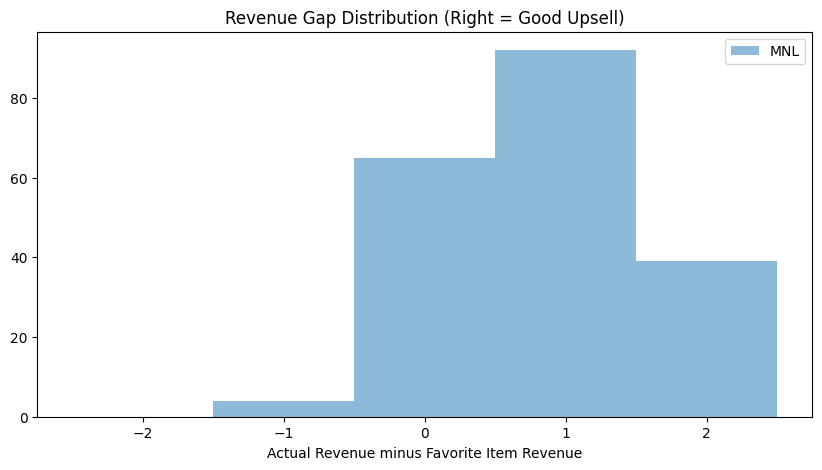

In [ ]:
# =============================================================================
# EXTENSION 2: REVENUE GAP ANALYSIS
# =============================================================================
def analyze_revenue_gap(report_df, users_df, restaurants_df):
    gap_data = []

    for _, row in report_df.iterrows():
        u_id = row['User ID'] if 'User ID' in row else row['user_id']
        actual_rev = row['Revenue']

        # Find True Favorite Price
        user = users_df[users_df['user_id'] == u_id].iloc[0]
        best_util = -np.inf
        fav_price = 0

        for _, rest in restaurants_df.iterrows():
            # Use your GT Utility function here
            # (Replace get_gt_utility with get_gt_features_and_utility if needed)
            u = get_gt_features_and_utility(user, rest)
            if u > best_util:
                best_util = u
                fav_price = rest['price_level']

        # Calculate Gap: (Actual - Favorite)
        # Positive = You upsold them!
        # Negative = You undersold them (or they settled for less)
        gap_data.append(actual_rev - fav_price)

    return pd.Series(gap_data)

# Calculate Gaps
mnl_gaps = analyze_revenue_gap(report_df, users, restaurants)

print(f"MNL Avg Upsell: ${mnl_gaps.mean():.2f}")

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.hist(mnl_gaps, alpha=0.5, label='MNL', bins=[-2.5, -1.5, -0.5, 0.5, 1.5, 2.5])
plt.legend()
plt.title("Revenue Gap Distribution (Right = Good Upsell)")
plt.xlabel("Actual Revenue minus Favorite Item Revenue")
plt.show()

Extension 3: Price sensitivity check

In [ ]:
# =============================================================================
# EXTENSION 3: PRICE SENSITIVITY MATRIX
# =============================================================================
# Merge Tolerance into the report
merged_mnl = report_df.merge(users[['user_id', 'price_tolerance']], left_on='User ID', right_on='user_id')

print("MNL: User Tolerance vs Chosen Price")
pd.crosstab(
    merged_mnl['price_tolerance'],
    merged_mnl['Revenue'],
    rownames=['User Tolerance'],
    colnames=['Chosen Price']
)

# Interpretation:
# Look at the diagonal.
# If Tolerance=1 users are buying Price=2 items, you are successfully upselling.
# If Tolerance=3 users are buying Price=1 items, you are failing to capture value.

MNL: User Tolerance vs Chosen Price


Chosen Price,1,2,3
User Tolerance,,,
1,15,20,40
2,4,18,43
3,0,0,60
